# Imports

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load Data (preprocess)

In [3]:
lock_meas  = '..\\..\\DATA\\RAW\\Measure_03\\Complex' # Location folder of the measurement files
meas_date  = '2018_ 11_ 26_12_40_05_'                 # Longest run, complex data set
stand_date = '2018_ 11_ 26_12_06_53_'                 # Use this file to calibrate ACCELERO
rotate_date= '2018_ 11_ 26_12_08_52_'                 # Use this file to calibraet MAGNETO

acc_calib = pd.read_csv(lock_meas + '\\StandStill\\' + stand_date + 'IMU.txt',
                               sep='\t',
                               decimal=',',
                               names=['time', 'acc0', 'acc1', 'acc2', 'gyro0', 'gyro1', 'gyro2', 'mag0', 'mag1', 'mag2'])

mag_calib = pd.read_csv(lock_meas + '\\Rotation\\' + rotate_date + 'IMU.txt',
                               sep='\t',
                               decimal=',',
                               names=['time', 'acc0', 'acc1', 'acc2', 'gyro0', 'gyro1', 'gyro2', 'mag0', 'mag1', 'mag2'])


# Load the IMU csv data file
imu_data = pd.read_csv(lock_meas + '\\LongRun\\' + meas_date + 'IMU.txt',
                               sep='\t',
                               decimal=',',
                               names=['time', 'acc0', 'acc1', 'acc2', 'gyro0', 'gyro1', 'gyro2', 'mag0', 'mag1', 'mag2'])

# Load the MoCap csv data file
mocap_data = pd.read_csv(lock_meas + '\\LongRun\\' + meas_date + 'MoCap.txt',
                                 sep='\t',
                                 decimal=',',
                                 names=['time', 'x', 'y', 'z', 'tracked', 'beta', 'Qx', 'Qy', 'Qz', 'Qw'])

# Merge the two data file to synronise them. In both dataset there are some data row that can't be matched, this data will
# be trown away
data = pd.merge(imu_data, mocap_data, on=['time'], how='inner')

# ===== Filters ======

# When the magneto sensors values are [0, 0, 0] that is a false value. These rows are deleted.
# When tacked is 0, it is indicates that the MoCap data is invalid. These rows are deleted too.
df = data[~(data[['mag0','mag1','mag2','tracked']] == 0).any(axis=1)]
# From now on the tracked column can be deleted, because it contains only 1s.
del df['tracked']
# Add to more columns to make a fluent orientation function (orient) and a delta time (deltat)
df = df.assign(orient=0)
df = df.assign(deltat=0)
df = df.assign(level=0)
# Convert the data frame into numpy array
dfarray = np.array(df)
# Create a lookup table to make the use of this matrix more readable.
time   = 0
acc0   = 1
acc1   = 2
acc2   = 3
gyro0  = 4
gyro1  = 5
gyro2  = 6
mag0   = 7
mag1   = 8
mag2   = 9
x      = 10
y      = 11
z      = 12
beta   = 13
Qx     = 14
Qy     = 15
Qz     = 16
Qw     = 17
orient = 18
deltat = 19
level  = 20

# Calculate the delta time between two valid measurements
for i in range(dfarray.shape[0]):
    if (i-1)>-1:
        dfarray[i,deltat] = dfarray[i,time]-dfarray[i-1,time]

# Creating a more fluent orientation function
level = 0
for i in range(dfarray.shape[0]):
    if (i-1)>-1:
        if (dfarray[i,beta]-dfarray[i-1,beta])>355:
            level = level - 1
        if (dfarray[i,beta]-dfarray[i-1,beta])<-355:
            level = level + 1
        else:
            level = level   
        dfarray[i, orient] = level*360 + dfarray[i, beta]

# Statistics

In [4]:
df.head(5)

,time,acc0,acc1,acc2,gyro0,gyro1,gyro2,mag0,mag1,mag2,...,y,z,beta,Qx,Qy,Qz,Qw,orient,deltat,level
8,124004.9159,0.003,-0.054,1.025,-0.906,-0.181,0.107,-0.321,-0.303,0.055,...,0.222,0.615,2.985,-0.017,0.026,-0.006,-1.0,0,0,0
13,124005.2640,0.002,-0.054,1.025,-0.564,0.101,-0.148,-0.321,-0.303,0.052,...,0.222,0.615,3.042,-0.016,0.026,-0.005,-1.0,0,0,0
14,124005.3188,0.003,-0.056,1.024,-0.967,0.101,-0.134,-0.324,-0.303,0.055,...,0.222,0.615,3.048,-0.016,0.027,-0.005,-1.0,0,0,0
19,124005.5562,0.003,-0.056,1.024,-0.463,0.383,0.081,-0.321,-0.303,0.055,...,0.222,0.615,2.988,-0.016,0.026,-0.006,-1.0,0,0,0
21,124005.5732,0.003,-0.056,1.024,-0.826,0.403,-0.148,-0.321,-0.303,0.055,...,0.221,0.615,3.033,-0.016,0.026,-0.005,-1.0,0,0,0


In [5]:
len(data)

8011

In [6]:
imu_data.head(5)

,time,acc0,acc1,acc2,gyro0,gyro1,gyro2,mag0,mag1,mag2
0,124004.6825,0.002,-0.055,1.025,-0.725,0.342,-0.121,0.000,0.000,0.000
1,124004.6885,0.003,-0.056,1.025,-0.806,0.222,-0.054,-0.321,-0.303,0.052
2,124004.6925,0.003,-0.056,1.025,-0.765,0.322,-0.054,0.000,0.000,0.000
3,124004.6965,0.003,-0.055,1.025,-0.745,0.040,0.121,-0.324,-0.300,0.055
4,124004.7005,0.002,-0.055,1.025,-0.826,0.141,0.121,0.000,0.000,0.000


# Graphs

In [20]:
acc_calib.describe()

,time,acc0,acc1,acc2,gyro0,gyro1,gyro2,mag0,mag1,mag2
count,3389.000000,3389.000000,3389.000000,3389.000000,3389.000000,3389.000000,3389.000000,3389.000000,3389.000000,3389.000000
mean,120682.122259,0.000637,-0.050991,1.022577,-0.671902,0.150767,-0.037727,-0.162008,-0.151793,0.039561
std,23.643636,0.001221,0.001845,0.035165,0.161595,0.155960,0.130792,0.164395,0.154030,0.040177
min,120653.325200,-0.004000,-0.053000,0.000000,-1.309000,-0.383000,-0.497000,-0.333000,-0.309000,0.000000
25%,120656.961100,0.000000,-0.051000,1.024000,-0.765000,0.040000,-0.121000,-0.330000,-0.309000,0.000000
50%,120700.565400,0.001000,-0.051000,1.024000,-0.685000,0.161000,-0.040000,0.000000,0.000000,0.000000
75%,120704.179300,0.001000,-0.051000,1.024000,-0.564000,0.262000,0.054000,0.000000,0.000000,0.079000
max,120707.805900,0.005000,0.000000,1.025000,0.000000,0.725000,0.443000,0.000000,0.000000,0.085000


In [22]:
acc0_mean = acc_calib["acc0"].mean()
acc1_mean = acc_calib["acc1"].mean()
acc2_mean = acc_calib["acc2"].mean()

mag0_mean = mag_calib["mag0"].mean()
mag1_mean = mag_calib["mag1"].mean()
mag2_mean = mag_calib["mag2"].mean()

mag0_std = mag_calib["mag0"].std()
mag1_std = mag_calib["mag1"].std()
mag2_std = mag_calib["mag2"].std()

0.0006370610799645914
-0.05099085275892595
1.0225771614045442


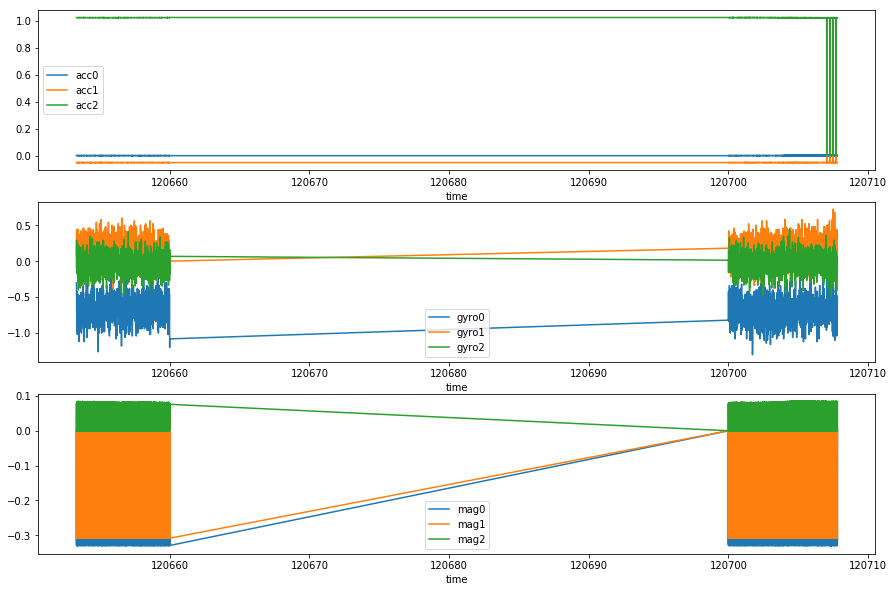

In [7]:
f1, (ax1, ax2, ax3) = plt.subplots(3, 1)
acc_calib.plot(x='time', y='acc0', figsize=(15,10), ax=ax1)
acc_calib.plot(x='time', y='acc1', ax=ax1)
acc_calib.plot(x='time', y='acc2', ax=ax1)
acc_calib.plot(x='time', y='gyro0', ax=ax2)
acc_calib.plot(x='time', y='gyro1', ax=ax2)
acc_calib.plot(x='time', y='gyro2', ax=ax2)
acc_calib.plot(x='time', y='mag0', ax=ax3)
acc_calib.plot(x='time', y='mag1', ax=ax3)
acc_calib.plot(x='time', y='mag2', ax=ax3)

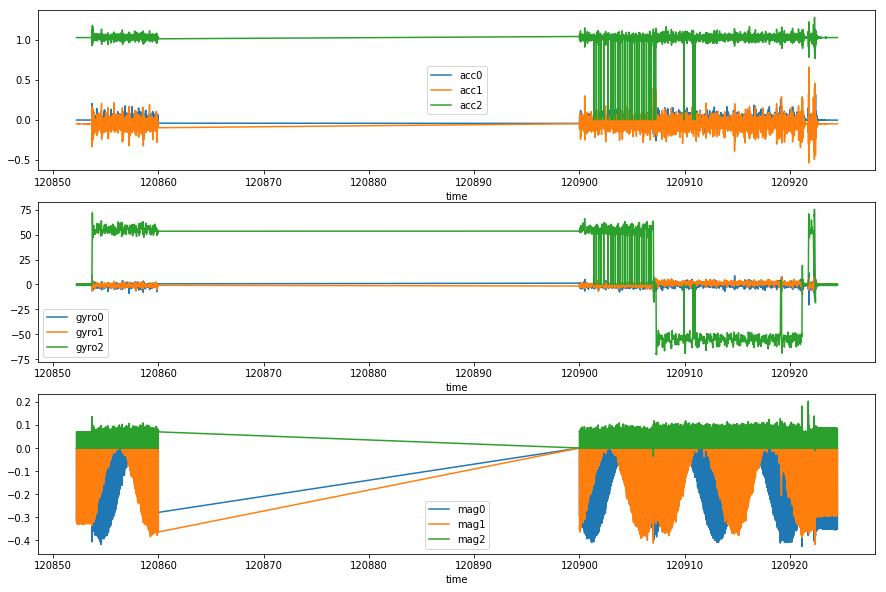

In [12]:
f1, (ax1, ax2, ax3) = plt.subplots(3, 1)
mag_calib.plot(x='time', y='acc0', figsize=(15,10), ax=ax1)
mag_calib.plot(x='time', y='acc1', ax=ax1)
mag_calib.plot(x='time', y='acc2', ax=ax1)
mag_calib.plot(x='time', y='gyro0', ax=ax2)
mag_calib.plot(x='time', y='gyro1', ax=ax2)
mag_calib.plot(x='time', y='gyro2', ax=ax2)
mag_calib.plot(x='time', y='mag0', ax=ax3)
mag_calib.plot(x='time', y='mag1', ax=ax3)
mag_calib.plot(x='time', y='mag2', ax=ax3)

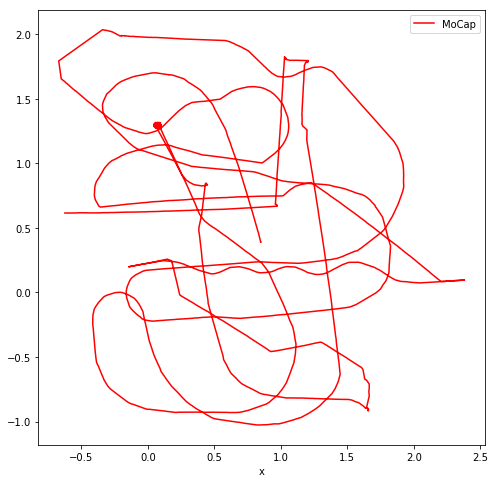

In [8]:
df.plot(x='x', y='z', color='red', figsize=(8,8), label='MoCap')

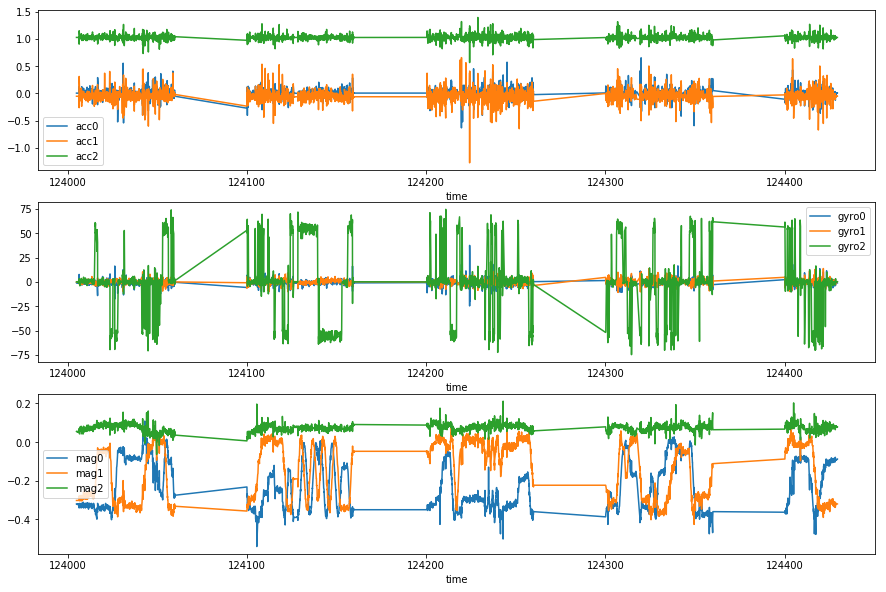

In [9]:
f1, (ax1, ax2, ax3) = plt.subplots(3, 1)
df.plot(x='time', y='acc0', figsize=(15,10), ax=ax1)
df.plot(x='time', y='acc1', ax=ax1)
df.plot(x='time', y='acc2', ax=ax1)
df.plot(x='time', y='gyro0', ax=ax2)
df.plot(x='time', y='gyro1', ax=ax2)
df.plot(x='time', y='gyro2', ax=ax2)
df.plot(x='time', y='mag0', ax=ax3)
df.plot(x='time', y='mag1', ax=ax3)
df.plot(x='time', y='mag2', ax=ax3)

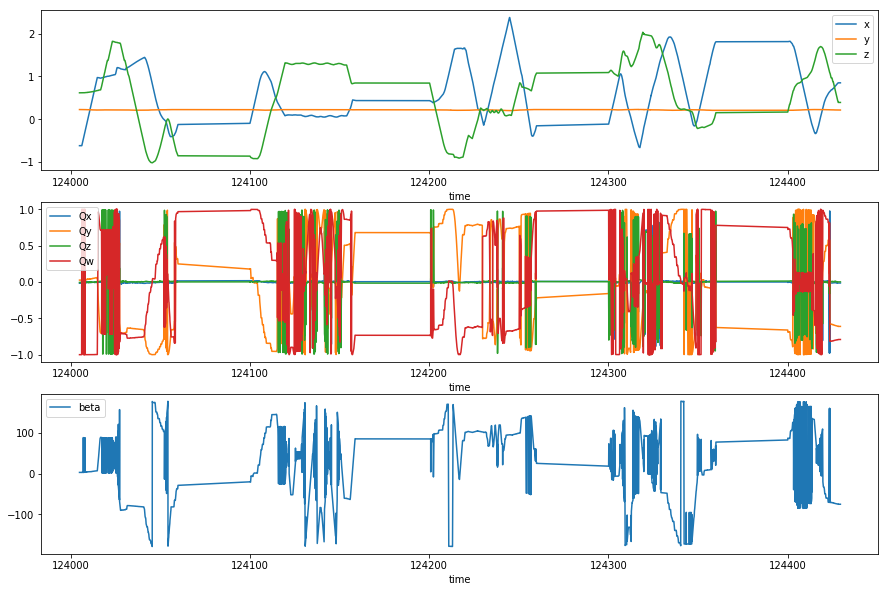

In [10]:
f2, (ax4, ax5, ax6) = plt.subplots(3, 1)
df.plot(x='time', y='x', figsize=(15,10), ax=ax4)
df.plot(x='time', y='y', ax=ax4)
df.plot(x='time', y='z', ax=ax4)
df.plot(x='time', y='Qx', ax=ax5)
df.plot(x='time', y='Qy', ax=ax5)
df.plot(x='time', y='Qz', ax=ax5)
df.plot(x='time', y='Qw', ax=ax5)
df.plot(x='time', y='beta', ax=ax6)

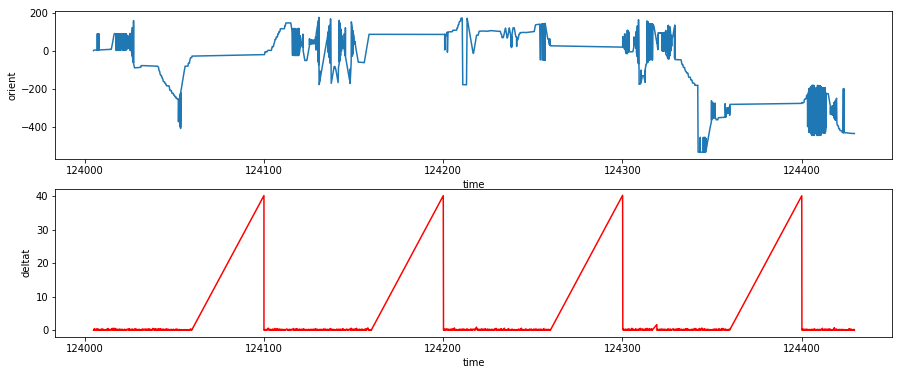

In [11]:
plt.figure(figsize=(15,6))
# equivalent but more general
ax1=plt.subplot(2, 1, 1)
ax1=plt.plot(dfarray[:,time],dfarray[:,orient])
plt.xlabel('time')
plt.ylabel('orient')

ax2=plt.subplot(212)
ax2=plt.plot(dfarray[:,time],dfarray[:,deltat], color="red")
plt.xlabel('time')
plt.ylabel('deltat')

plt.show()